# Exploration 9
---
## Movielens Recommender System 🎬

### Table of contents
1. [Problem Definition]()
2. [Import necessary Libraries]()
3. [EDA]()
4. [Add my favorite movies]()
5. [csr_matrix]()
6. [summary]()

### 평가기준

아래의 기준을 바탕으로 프로젝트를 평가합니다.


|평가문항|	상세기준|
|:------|:--------|
|1. CSR matrix가 정상적으로 만들어졌다.| 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.|
|2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.| 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.|
|3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다. |MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다.|

## 1. Problem Definition
---

**사용데이터**
```
MovieLens 1M Dataset
MovieLens 1M movie ratings. Stable benchmark dataset. 1 million ratings from 6000 users on 4000 movies. Released 2/2003.
```
MovieLens 1M Dataset을 사용하여 영화 추천시스템을 만들어보자 🙌

Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다.

데이터에 대한 보다 자세한 설명은 [MovieLens README](https://files.grouplens.org/datasets/movielens/ml-1m-README.txt)에서 확인 해주세요!

## 2. Import necessary Libraries
---

####  ratings.dat

```
user_id, movie_id, rating, timestamp을 컬럼으로 가지는 데이터를 
pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")로 저장한다

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

```

#### movies.dat 

```
movie_id, title, genre를 담고 있는 데이터로 위와 마찬가지로 
pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')를 통해 데이터를 저장한다.

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including year of release)
- Genres are pipe-separated(|) and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western
```

In [1]:
import os
import pandas as pd

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [3]:
# rating 컬럼의 이름을 count로 바꿉니다.
ratings.rename(columns={'rating':'count'}, inplace=True)

In [4]:
ratings['count']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: count, Length: 836478, dtype: int64

In [5]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# movie_id는 3952까지 존재
movies.tail()

,movie_id,title,genre
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


**1) ratings에 있는 유니크한 영화 개수**

In [7]:
ratings['movie_id'].nunique()

3628

**2) ratings에 있는 유니크한 사용자 수**

In [8]:
# 2) rating에 있는 유니크한 사용자 수
ratings['user_id'].nunique()

6039

**3) 가장 인기 있는 영화 30개(인기순)**

In [9]:
# movie_id를 key로 ratings와 movies 데이터프레임을 조인
ratings = ratings.merge(movies, how='left', on='movie_id')

In [10]:
ratings.groupby('title')['user_id'].count().sort_values(ascending=False)[:30]

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

In [11]:
ratings

,user_id,movie_id,count,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy
...,...,...,...,...,...,...
836473,6040,1090,3,956715518,Platoon (1986),Drama|War
836474,6040,1094,5,956704887,"Crying Game, The (1992)",Drama|Romance|War
836475,6040,562,5,956704746,Welcome to the Dollhouse (1995),Comedy|Drama
836476,6040,1096,4,956715648,Sophie's Choice (1982),Drama


In [12]:
# ratings의 데이터타입 체크
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 836477
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    836478 non-null  int64 
 1   movie_id   836478 non-null  int64 
 2   count      836478 non-null  int64 
 3   timestamp  836478 non-null  int64 
 4   title      836478 non-null  object
 5   genre      836478 non-null  object
dtypes: int64(4), object(2)
memory usage: 44.7+ MB


## 3. EDA
1. Missing Value
2. unique genres
3. timestamp
4. Extracting the year from the Title
5. rating

### 3.1 Missing Value

In [13]:
# 결측값 존재 여부를 체크해보자
ratings.isnull().sum()

user_id      0
movie_id     0
count        0
timestamp    0
title        0
genre        0
dtype: int64

## 3.2 Unique Genre

In [14]:
# genre는 pipe-separated(|)로 구분 되어있으므로 unique한 genre가 무엇이 있는지 확인해보자
genres = list(movies['genre'].value_counts().keys())
genres[:20]

['Drama',
 'Comedy',
 'Horror',
 'Comedy|Drama',
 'Comedy|Romance',
 'Drama|Romance',
 'Documentary',
 'Thriller',
 'Action',
 'Drama|Thriller',
 'Action|Thriller',
 "Children's|Comedy",
 'Crime|Drama',
 'Drama|War',
 'Romance',
 'Action|Drama',
 "Animation|Children's",
 'Comedy|Drama|Romance',
 'Western',
 'Horror|Sci-Fi']

In [15]:
from collections import Counter

result = [] # 중복을 포함해서 genre 출현 빈도를 count
for genre in ratings['genre']:
    result.extend(genre.split('|'))

In [16]:
genre_counter = Counter(result)
genre_counter

Counter({'Drama': 313261,
         'Animation': 37609,
         "Children's": 57674,
         'Musical': 35661,
         'Romance': 125927,
         'Comedy': 293891,
         'Action': 209494,
         'Adventure': 108818,
         'Fantasy': 29205,
         'Sci-Fi': 126089,
         'War': 61226,
         'Thriller': 158343,
         'Crime': 68889,
         'Mystery': 34417,
         'Western': 17668,
         'Horror': 55488,
         'Film-Noir': 17166,
         'Documentary': 7162})

In [17]:
sorted_genre_counter = genre_counter.most_common()
sorted_genre_counter

[('Drama', 313261),
 ('Comedy', 293891),
 ('Action', 209494),
 ('Thriller', 158343),
 ('Sci-Fi', 126089),
 ('Romance', 125927),
 ('Adventure', 108818),
 ('Crime', 68889),
 ('War', 61226),
 ("Children's", 57674),
 ('Horror', 55488),
 ('Animation', 37609),
 ('Musical', 35661),
 ('Mystery', 34417),
 ('Fantasy', 29205),
 ('Western', 17668),
 ('Film-Noir', 17166),
 ('Documentary', 7162)]

[**Plotly**](https://plotly.com/)를 사용해서 시각화 합니다.🤩🤩

In [18]:
!pip install plotly

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [19]:
# Horizontal bar

import pandas as pd
import plotly.express as px

import plotly.io as pio
pio.renderers.default = 'notebook_connected'

sorted_genre_counter_df = pd.DataFrame(sorted_genre_counter, columns=['genre', 'count'])

fig = px.bar(sorted_genre_counter_df, x='count', y='genre', orientation='h')

fig.show()

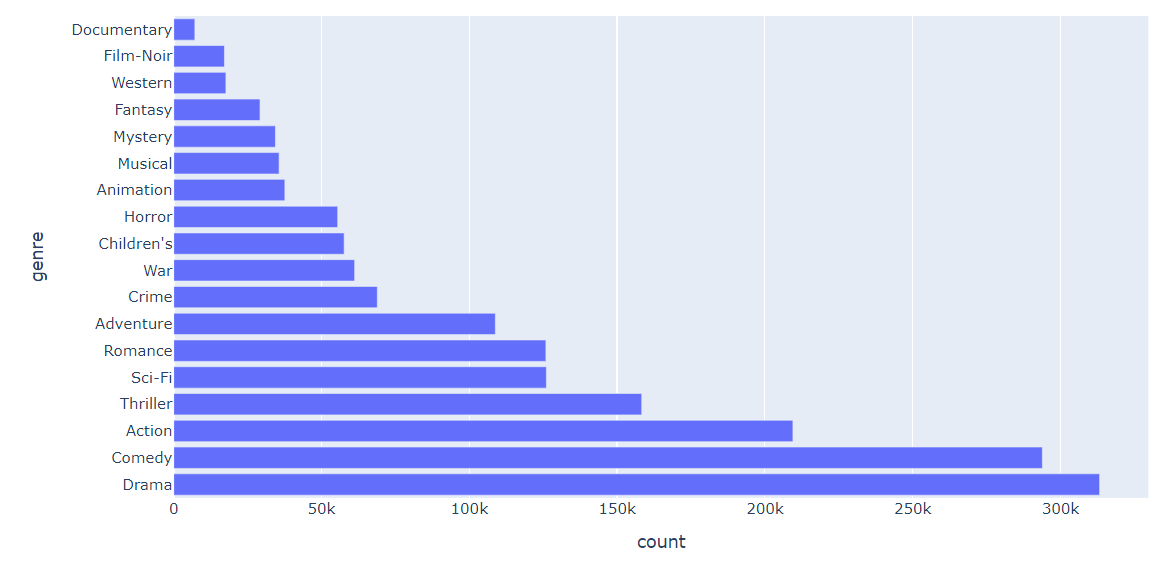

In [20]:
# Pie chart
fig = px.pie(sorted_genre_counter_df, values='count', names='genre', title='Pie chart for Genre')
fig.show()

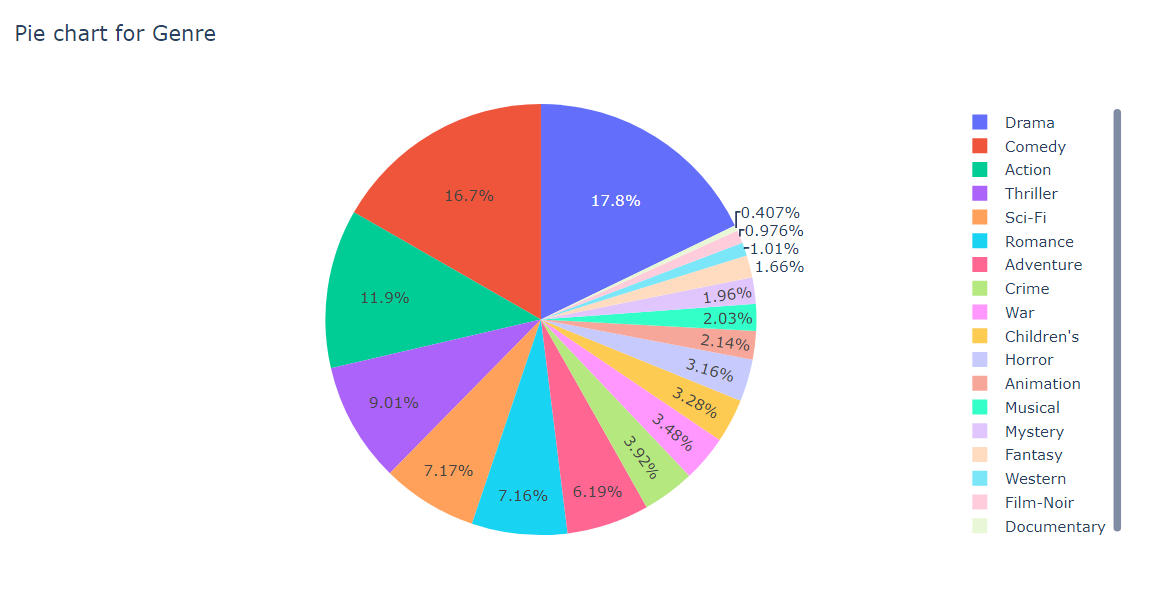

In [21]:
# helper function
def get_unique_genre(genres):
    result = [] # unique 장르를 담을 list
    for genre in genres:
        result.extend(genre.split('|'))
    return sorted(set(result))

In [22]:
# unique한 genre는 다음과 같다.
unique_genres = get_unique_genre(genres)
unique_genres.sort
print(unique_genres)

['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


## 3.3 timestamp
Timestamp에 대한 데이터 설명이 Timestamp is represented in seconds since the epoch as returned by time(2)

타임스탬프는 epoch 이후 시간(2)으로 표시됩니다. 라고 해석이 되는데 무슨 의미인지(?) 모르겠습니다

일단 datetime을 이용하여 타임스탬프로 저장된 시간값을 특정 날짜포맷(년/월/일/시간)으로 변경해봅니다

In [23]:
ratings.head()

,user_id,movie_id,count,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [24]:
from datetime import datetime
import time
s = int('978300760')

In [25]:
datetime.fromtimestamp(s).strftime('%Y-%m-%d')

'2000-12-31'

In [26]:
# timestamp를 %Y-%m-%d 형식으로 변경해봅니다.
# ratings.rename(columns={'timestamp' : 'date'}, inplace=True)
ratings['timestamp'] = ratings['timestamp'].apply(lambda s : datetime.fromtimestamp(int(s)).strftime('%Y-%m-%d'))

In [27]:
# 여전히 timestamp의 의미가 해석되지 않아서 나중에 drop 하겠습니다. 
ratings.head()

,user_id,movie_id,count,timestamp,title,genre
0,1,1193,5,2000-12-31,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,2000-12-31,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,2000-12-31,My Fair Lady (1964),Musical|Romance
3,1,3408,4,2000-12-31,Erin Brockovich (2000),Drama
4,1,2355,5,2001-01-06,"Bug's Life, A (1998)",Animation|Children's|Comedy


### 3.4 year

timestamp에서 유용한 정보를 얻지 못했으므로 title에 있는 year 정보를 추출하여 시각화 해봅니다.

In [28]:
ratings['year'] = ratings['title'].str.extract('.*\((.*)\).*',expand = False).astype(int)

In [29]:
ratings.head()

,user_id,movie_id,count,timestamp,title,genre,year
0,1,1193,5,2000-12-31,One Flew Over the Cuckoo's Nest (1975),Drama,1975
1,1,661,3,2000-12-31,James and the Giant Peach (1996),Animation|Children's|Musical,1996
2,1,914,3,2000-12-31,My Fair Lady (1964),Musical|Romance,1964
3,1,3408,4,2000-12-31,Erin Brockovich (2000),Drama,2000
4,1,2355,5,2001-01-06,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998


In [30]:
ratings

,user_id,movie_id,count,timestamp,title,genre,year
0,1,1193,5,2000-12-31,One Flew Over the Cuckoo's Nest (1975),Drama,1975
1,1,661,3,2000-12-31,James and the Giant Peach (1996),Animation|Children's|Musical,1996
2,1,914,3,2000-12-31,My Fair Lady (1964),Musical|Romance,1964
3,1,3408,4,2000-12-31,Erin Brockovich (2000),Drama,2000
4,1,2355,5,2001-01-06,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998
...,...,...,...,...,...,...,...
836473,6040,1090,3,2000-04-26,Platoon (1986),Drama|War,1986
836474,6040,1094,5,2000-04-25,"Crying Game, The (1992)",Drama|Romance|War,1992
836475,6040,562,5,2000-04-25,Welcome to the Dollhouse (1995),Comedy|Drama,1995
836476,6040,1096,4,2000-04-26,Sophie's Choice (1982),Drama,1982


In [31]:
# 가장 인기있는 영화 top 10을 시각화 해봅니다.

import plotly.graph_objects as go

movies_top10 = ratings.groupby('title')['user_id'].count().sort_values(ascending=False)[:10]

fig = go.Figure(data=go.Scatter(
    x=movies_top10.index,
    y=movies_top10.values,
    mode='markers',
    marker=dict(size=[100,90,80,70,60,50,40,30,20,10],
                color=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
))

fig.show()

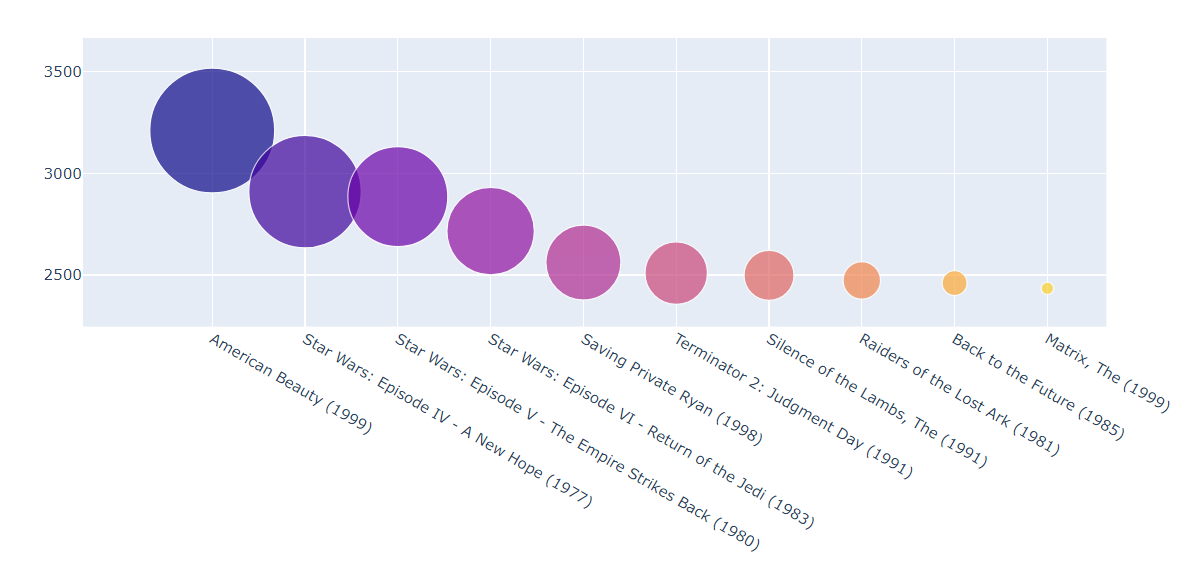

In [32]:
# 90년대 인기 영화 top 10을 시각화

cond1 = 'year >= 1990 and year <= 2000' 
movies_90s = ratings.query(cond1)
movies_90s_top10 = movies_90s.groupby('title')['user_id'].count().sort_values(ascending=False)[:10]

fig1 = go.Figure(data=go.Scatter(
    x=movies_90s_top10.index,
    y=movies_90s_top10.values,
    mode='markers',
    marker=dict(size=[100,90,80,70,60,50,40,30,20,10],
                color=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
))

fig1.show()

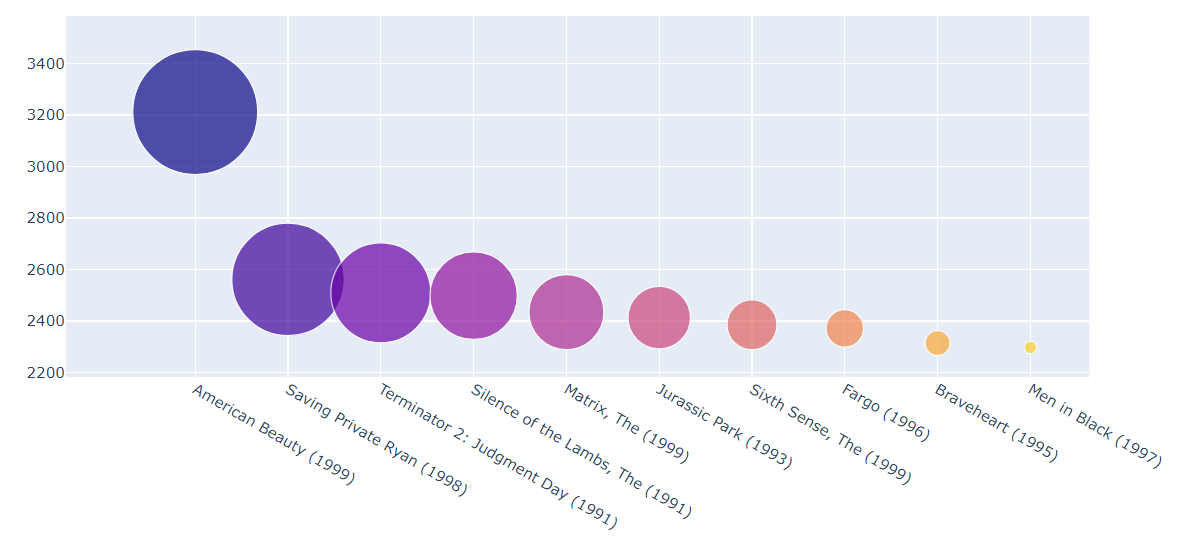

In [33]:
# 80년대 인기 영화 top 10

cond2 = 'year >= 1980 and year < 1990' 
movies_80s = ratings.query(cond2)
movies_80s_top10 = movies_80s.groupby('title')['user_id'].count().sort_values(ascending=False)[:10]

fig2 = go.Figure(data=go.Scatter(
    x=movies_80s_top10.index,
    y=movies_80s_top10.values,
    mode='markers',
    marker=dict(size=[100,90,80,70,60,50,40,30,20,10],
                color=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
))

fig2.show()

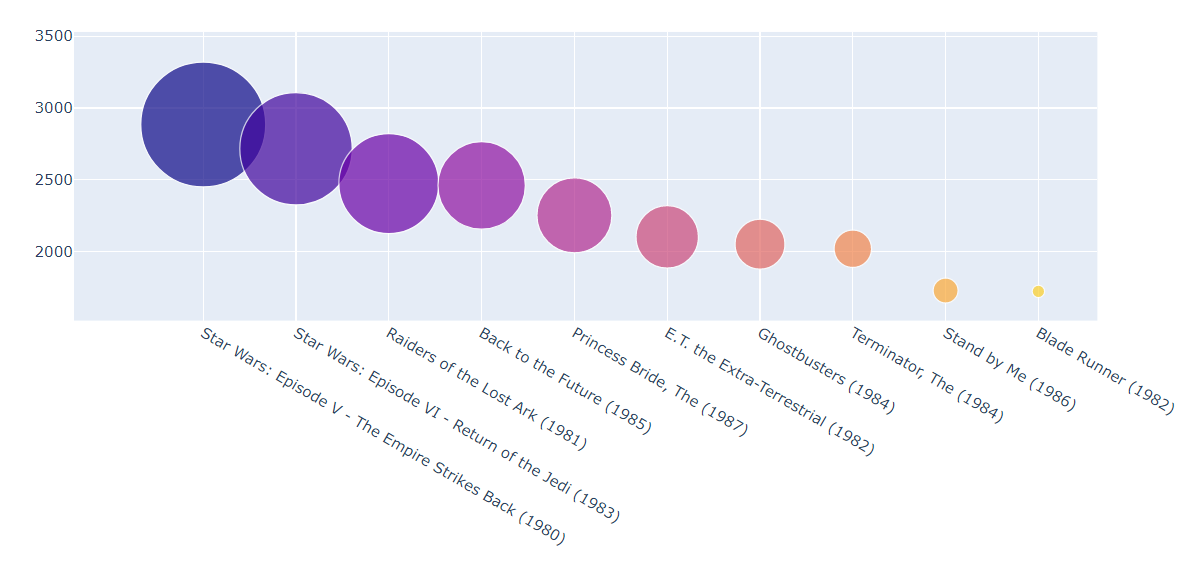

In [34]:
# 70년대 인기 영화 top 10

cond3 = 'year >= 1970 and year < 1980' 
movies_70s = ratings.query(cond3)
movies_70s_top10 = movies_70s.groupby('title')['user_id'].count().sort_values(ascending=False)[:10]

fig3 = go.Figure(data=go.Scatter(
    x=movies_70s_top10.index,
    y=movies_70s_top10.values,
    mode='markers',
    marker=dict(size=[100,90,80,70,60,50,40,30,20,10],
                color=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
))

fig3.show()

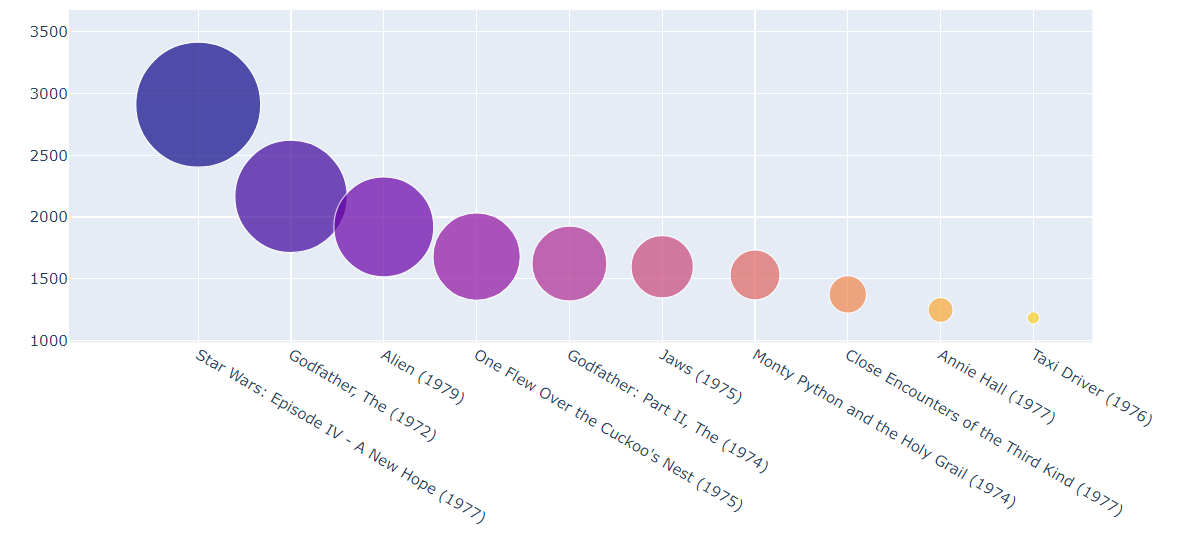

### 3.5 rating

평점분포가 어떻게 되어있는지 시각화 해보자
시간의 흐름에 따라 많은 영화가 개봉하고 있고 다양한 평점 분포를 보인다.
평균 평점 4.5 이상의 영화는 많이 없는 것 같다.

In [35]:
avg_ratings = ratings[['movie_id', 'count', 'year']].groupby('movie_id').mean()

fig = px.scatter(avg_ratings, x="year", y="count", color='count')
fig.show()

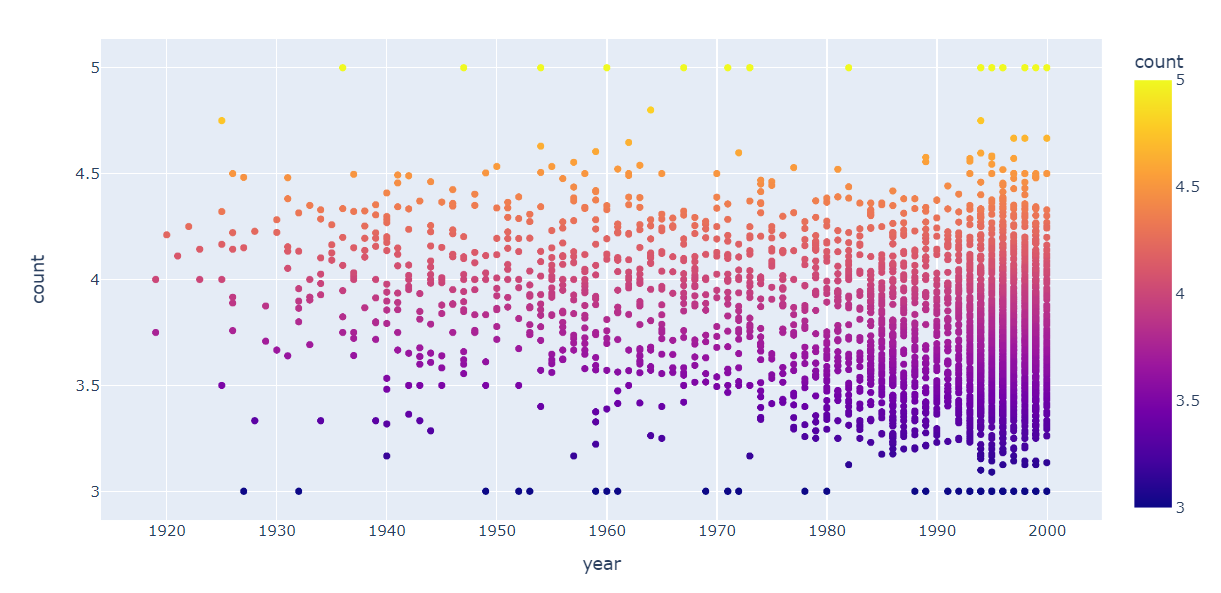

## 4. Add my favorite movies

- user_id : 기존 id가 6040까지 있으므로 내 id는 6041으로 설정한다.
- movie_id : 내가 선택할 영화의 id가 리스트에 존재한다면 해당 id로 설정하고
그렇지 않다면 3952 이후로 설정 
- count : 내가 좋아하는 영화이므로 5점을 부여
- title : title 형식에 맞게 '제목 (연도)'로 전처리
- genre : 장르가 여러개 존재할 경우 |로 연결 

In [36]:
# 2000년 이전 영화 중에서 내가 좋아하는 영화 5가지를 선택한다.

# 라이언 일병 구하기 Saving Private Ryan, 1998 War, Action, Drama
# 인생은 아름다워 Life Is Beautiful, 1997, Drama, Comedy
# 쇼생크 탈출 The Shawshank Redemption, 1994, Drama
# 타이타닉 Titanic, 1997, Romance, Drama
# 매트릭스 The Matrix, 1999 Sci-Fi, Action

# 영화 하나 하나 검색하며 title이 일치하는지 여부를 확인한다.

favorite_movies = ['Saving Private Ryan (1998)',
                   'Life Is Beautiful (1997)',
                   'The Shawshank Redemption (1994)',
                   'Titanic (1997)',
                   'The Matrix (1999)']

In [37]:
# 라이언 일병 구하기
movie_name = 'Saving Private Ryan (1998)'
ratings[ratings['title'].apply(lambda x : x == movie_name)]

,user_id,movie_id,count,timestamp,title,genre,year
48,1,2028,5,2000-12-31,Saving Private Ryan (1998),Action|Drama|War,1998
102,2,2028,4,2000-12-31,Saving Private Ryan (1998),Action|Drama|War,1998
221,4,2028,5,2000-12-31,Saving Private Ryan (1998),Action|Drama|War,1998
473,7,2028,5,2000-12-31,Saving Private Ryan (1998),Action|Drama|War,1998
571,8,2028,5,2000-12-31,Saving Private Ryan (1998),Action|Drama|War,1998
...,...,...,...,...,...,...,...
834644,6027,2028,5,2000-04-26,Saving Private Ryan (1998),Action|Drama|War,1998
835008,6033,2028,5,2000-04-26,Saving Private Ryan (1998),Action|Drama|War,1998
835862,6036,2028,5,2000-04-26,Saving Private Ryan (1998),Action|Drama|War,1998
836059,6037,2028,4,2000-04-26,Saving Private Ryan (1998),Action|Drama|War,1998


In [38]:
# 인생은 아름다워
# Life Is Beautiful (1997)으로는 인덱싱이 되지 않는다'
# 제목을 'Life Is Beautiful (La Vita è bella) (1997)'로 수정한다.

movie_name = 'Life Is Beautiful (1997)'
favorite_movies[1] = 'Life Is Beautiful (La Vita è bella) (1997)'
ratings[ratings['title'].apply(lambda x : x[:4] == 'Life')]

,user_id,movie_id,count,timestamp,title,genre,year
595,8,2324,3,2000-12-31,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1997
698,9,2324,5,2000-12-31,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1997
885,10,2324,5,2000-12-31,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1997
1673,17,2377,5,2000-12-30,Lifeforce (1985),Horror|Sci-Fi,1985
2078,19,2324,5,2001-01-03,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1997
...,...,...,...,...,...,...,...
835133,6035,2324,5,2000-04-26,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1997
835728,6036,2324,4,2000-04-26,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1997
835756,6036,2377,3,2000-04-26,Lifeforce (1985),Horror|Sci-Fi,1985
836038,6037,2324,4,2000-04-26,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1997


In [39]:
# 쇼생크 탈출
# 쇼생크 탈출 제목도 Shawshank Redemption, The로 되어있기 떄문에 제목을 수정한다.
movie_name = 'Shawshank Redemption (1994)'
movies[2] = 'Shawshank Redemption, The (1994)'
movies[movies['title'].apply(lambda x : (x[:4] == 'Shaw'))] 

,movie_id,title,genre,2
315,318,"Shawshank Redemption, The (1994)",Drama,"Shawshank Redemption, The (1994)"


In [40]:
# 타이타닉 
movie_name = 'Titanic (1997)'
ratings[ratings['title'].apply(lambda x : x == movie_name)]

,user_id,movie_id,count,timestamp,title,genre,year
27,1,1721,4,2000-12-31,Titanic (1997),Drama|Romance,1997
557,8,1721,5,2000-12-31,Titanic (1997),Drama|Romance,1997
672,9,1721,5,2000-12-31,Titanic (1997),Drama|Romance,1997
1027,10,1721,3,2001-01-10,Titanic (1997),Drama|Romance,1997
1934,18,1721,4,2000-12-30,Titanic (1997),Drama|Romance,1997
...,...,...,...,...,...,...,...
833544,6016,1721,3,2000-04-28,Titanic (1997),Drama|Romance,1997
834214,6023,1721,5,2000-04-26,Titanic (1997),Drama|Romance,1997
834500,6025,1721,4,2000-04-26,Titanic (1997),Drama|Romance,1997
834642,6027,1721,4,2000-04-26,Titanic (1997),Drama|Romance,1997


In [41]:
# 매트릭스
# 매트릭스는 Matrix, The (1999)로 수정한다.
movie_name = 'The Matrix (1999)'
favorite_movies[4] = 'Matrix, The (1999)' 
ratings[ratings['title'].apply(lambda x : x[:6] == 'Matrix')]

,user_id,movie_id,count,timestamp,title,genre,year
127,2,2571,4,2000-12-31,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999
286,5,2571,5,2000-12-31,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999
459,7,2571,5,2000-12-31,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999
517,8,2571,5,2000-12-31,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999
640,9,2571,5,2000-12-31,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999
...,...,...,...,...,...,...,...
834757,6030,2571,5,2000-04-26,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999
834829,6031,2571,5,2000-04-26,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999
835072,6035,2571,5,2000-04-26,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999
835456,6036,2571,3,2000-04-26,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999


In [42]:
favorite_movies

['Saving Private Ryan (1998)',
 'Life Is Beautiful (La Vita è bella) (1997)',
 'The Shawshank Redemption (1994)',
 'Titanic (1997)',
 'Matrix, The (1999)']

In [43]:
my_movies = {
    'user_id' : [6041] * 5,
    'movie_id' : [2028, 2324, 318, 1721, 2571],
    'count' : [5]*5,
    'title' : favorite_movies,
    'genre': ['Action|Drama|War',
             'Comedy|Drama',
             'Drama',
             'Drama|Romance',
             'Action|Sci-Fi|Thriller']
}

In [44]:
my_movies_df = pd.DataFrame(my_movies)

In [45]:
ratings = ratings.append(my_movies_df, ignore_index=True)

In [46]:
ratings.tail(10)

,user_id,movie_id,count,timestamp,title,genre,year
836473,6040,1090,3,2000-04-26,Platoon (1986),Drama|War,1986.0
836474,6040,1094,5,2000-04-25,"Crying Game, The (1992)",Drama|Romance|War,1992.0
836475,6040,562,5,2000-04-25,Welcome to the Dollhouse (1995),Comedy|Drama,1995.0
836476,6040,1096,4,2000-04-26,Sophie's Choice (1982),Drama,1982.0
836477,6040,1097,4,2000-04-26,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,1982.0
836478,6041,2028,5,NaN,Saving Private Ryan (1998),Action|Drama|War,NaN
836479,6041,2324,5,NaN,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,NaN
836480,6041,318,5,NaN,The Shawshank Redemption (1994),Drama,NaN
836481,6041,1721,5,NaN,Titanic (1997),Drama|Romance,NaN
836482,6041,2571,5,NaN,"Matrix, The (1999)",Action|Sci-Fi|Thriller,NaN


In [47]:
# 이제 필요한 칼럼만 남기고 제거한다.
ratings.drop(['timestamp', 'genre', 'year'], axis=1, inplace=True)

In [48]:
ratings

,user_id,movie_id,count,title
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975)
1,1,661,3,James and the Giant Peach (1996)
2,1,914,3,My Fair Lady (1964)
3,1,3408,4,Erin Brockovich (2000)
4,1,2355,5,"Bug's Life, A (1998)"
...,...,...,...,...
836478,6041,2028,5,Saving Private Ryan (1998)
836479,6041,2324,5,Life Is Beautiful (La Vita è bella) (1997)
836480,6041,318,5,The Shawshank Redemption (1994)
836481,6041,1721,5,Titanic (1997)


In [49]:
# user_id와 title의 unique 값을 저장
user_unique = ratings['user_id'].unique()
movie_unique = ratings['title'].unique()

# unique 값의 개수만큼 user_id와 title을 indexing
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [50]:
# 데이터 컬럼 내 값을 indexing된 값으로 교체

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# movie_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = ratings['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(ratings):
    print('title column indexing OK!!')
    ratings['title'] = temp_movie_data
else:
    print('title column indexing Fail!!')

ratings

user_id column indexing OK!!
title column indexing OK!!


,user_id,movie_id,count,title
0,0,1193,5,0
1,0,661,3,1
2,0,914,3,2
3,0,3408,4,3
4,0,2355,5,4
...,...,...,...,...
836478,6039,2028,5,48
836479,6039,2324,5,450
836480,6039,318,5,3628
836481,6039,1721,5,27


## 5. CSR_MATRIX

In [51]:
from scipy.sparse import csr_matrix

# CSR Matrix 생성
num_user = ratings['user_id'].nunique()
num_movie = ratings['title'].nunique()

csr_data = csr_matrix((ratings['count'], (ratings.user_id, ratings.title)), shape= (num_user, num_movie))
csr_data

<6040x3629 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [52]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [53]:
# AlternatingLeastSquares
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [54]:
# als 모델은 input으로 item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.
csr_data_transpose = csr_data.T
csr_data_transpose

<3629x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [55]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [56]:
# 훈련된 모델이 만든 나의 벡터와 영화 벡터 구하기
my_vector, matrix = user_to_idx[6041], movie_to_idx['Matrix, The (1999)']
my_vector, matrix_vector = als_model.user_factors[my_vector], als_model.item_factors[matrix]

In [57]:
my_vector

array([-0.36430427, -0.5922591 ,  0.17357141,  0.23793331,  0.51160276,
        0.26814306,  0.250637  ,  0.42869917, -0.33430088, -0.09175824,
        0.42495975, -0.32955062, -0.29059485,  0.6051782 ,  0.0612339 ,
        0.5441835 ,  0.4725688 , -0.1403681 ,  0.664474  , -0.3261237 ,
        0.07685981, -0.781979  , -0.1450938 , -0.25702372,  0.26318634,
        0.04644935, -0.7352746 ,  0.19586521, -0.44585106,  0.13624986,
       -0.41224283,  0.93174994, -0.39820465,  0.84379256, -0.7302619 ,
        0.23721698,  0.37102532, -0.8027221 , -0.5896009 , -0.20055756,
        0.32182586,  0.31904483,  0.46717247,  0.31691197,  0.5682978 ,
        0.5219425 ,  0.63093394, -0.31474864, -0.7748069 , -0.6813735 ,
        0.42348176, -0.15184805, -0.16101207, -0.4290488 , -0.47428313,
        0.27201018,  0.67443246, -1.0610999 ,  0.3131199 ,  0.22529005,
        0.45065558,  0.04387408, -0.2286943 ,  0.61198306,  0.01640972,
        0.08252177, -0.09969816,  0.9866736 ,  0.4315465 , -0.73

In [58]:
matrix_vector

array([-8.2622180e-03,  3.3971858e-03,  7.2217090e-03,  2.5938053e-03,
        2.0688942e-02,  2.3896430e-02,  1.5741911e-02,  4.8212297e-03,
        4.8652706e-03,  9.9453963e-03,  8.9216670e-03, -4.8450683e-03,
       -3.4159441e-02,  1.2042129e-02,  1.8985251e-02, -4.7484287e-03,
        4.0414251e-02,  1.1633391e-02,  3.8013082e-02, -5.5071507e-03,
       -1.4120766e-03, -1.0579001e-02,  1.8488836e-02, -9.5647527e-03,
        3.4266927e-03,  1.9434221e-02,  1.1593812e-02,  2.0119291e-02,
        1.8303077e-03, -1.5767295e-02,  1.8151017e-03,  1.5589624e-02,
       -5.4668970e-03,  2.0217882e-02, -2.9446257e-02,  5.3431941e-03,
        3.5242497e-03, -2.0136712e-02,  1.5979070e-02, -1.7914657e-03,
       -1.2752089e-02,  3.3473402e-02,  3.3442784e-02,  2.7416628e-02,
        2.3054970e-02,  6.6180895e-03,  3.6438971e-03, -1.6274994e-02,
       -3.1074584e-03, -5.6026824e-04,  1.3681049e-02,  7.9895929e-03,
        2.4469288e-02, -1.0141123e-03, -2.4670279e-02, -1.8028131e-02,
      

In [59]:
# 라이언 일병 구하기를 좋아한다!
favorite_movie = 'Saving Private Ryan (1998)'
movie_id = movie_to_idx[favorite_movie]
similar_movie = als_model.similar_items(movie_id, N=15)
similar_movie

[(48, 1.0000001),
 (23, 0.6399153),
 (87, 0.6348853),
 (157, 0.48838192),
 (487, 0.45386222),
 (248, 0.40377364),
 (141, 0.4020457),
 (3628, 0.39461055),
 (121, 0.39306125),
 (988, 0.35501876),
 (124, 0.35436904),
 (99, 0.34284383),
 (3499, 0.3361102),
 (238, 0.3221027),
 (768, 0.31142086)]

In [60]:
# 라이언 일병 구하기와 유사한 추천 영화 15개
# 쇼생크 탈출이 두개 보이고.. 쉰들러 리스트는 좋아하는 영화다!
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

['Saving Private Ryan (1998)',
 "Schindler's List (1993)",
 'Braveheart (1995)',
 'Shawshank Redemption, The (1994)',
 'Boat, The (Das Boot) (1981)',
 'Good Will Hunting (1997)',
 'Fugitive, The (1993)',
 'The Shawshank Redemption (1994)',
 'Silence of the Lambs, The (1991)',
 'Glory (1989)',
 'Matrix, The (1999)',
 'American Beauty (1999)',
 'Simon Sez (1999)',
 'Thin Red Line, The (1998)',
 'Get Shorty (1995)']

In [61]:
# 비슷한 영화를 알려주는 함수
def get_similar_movie(movie_title):
    movie_id = movie_to_idx[movie_title]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [62]:
# 쉰들러리스트와 유사한 영화
get_similar_movie("Schindler's List (1993)")

["Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'Saving Private Ryan (1998)',
 'Silence of the Lambs, The (1991)',
 'Good Will Hunting (1997)',
 'Pulp Fiction (1994)',
 'GoodFellas (1990)',
 'Braveheart (1995)',
 'Fargo (1996)',
 'Held Up (2000)']

In [63]:
# 레옹도 좋아한다. 이중에서 SEVEN도 좋아하는 영화이다.
get_similar_movie('Professional, The (a.k.a. Leon: The Professional) (1994)')

['Professional, The (a.k.a. Leon: The Professional) (1994)',
 'Nikita (La Femme Nikita) (1990)',
 'Reservoir Dogs (1992)',
 'Seven (Se7en) (1995)',
 'Bound (1996)',
 'Heat (1995)',
 'Killing Zoe (1994)',
 "Carlito's Way (1993)",
 'True Romance (1993)',
 'King of New York (1990)']

In [64]:
# 'Pulp Fiction (1994)'도 좋아한다
get_similar_movie('Pulp Fiction (1994)')

['Pulp Fiction (1994)',
 'GoodFellas (1990)',
 'Fargo (1996)',
 'Usual Suspects, The (1995)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Reservoir Dogs (1992)',
 'Good Will Hunting (1997)',
 'Seven (Se7en) (1995)',
 'L.A. Confidential (1997)']

In [65]:
# 나를 위한 영화 추천
for_me = user_to_idx[6041]
recommended_movie = als_model.recommend(for_me, csr_data, N=20, filter_already_liked_items=True)
recommended_movie

[(87, 0.39847022),
 (23, 0.39259896),
 (92, 0.3094918),
 (99, 0.28399235),
 (157, 0.2820685),
 (141, 0.28155133),
 (38, 0.26967567),
 (248, 0.25976682),
 (121, 0.25761253),
 (60, 0.2500215),
 (81, 0.24155585),
 (67, 0.23009408),
 (107, 0.22362483),
 (154, 0.21330854),
 (146, 0.20578544),
 (175, 0.20502627),
 (22, 0.1988533),
 (126, 0.19836976),
 (160, 0.18163332),
 (988, 0.18139073)]

In [66]:
# 인덱스를 영화 제목으로 변환
[idx_to_movie[i[0]] for i in recommended_movie]

['Braveheart (1995)',
 "Schindler's List (1993)",
 'Terminator 2: Judgment Day (1991)',
 'American Beauty (1999)',
 'Shawshank Redemption, The (1994)',
 'Fugitive, The (1993)',
 'Sixth Sense, The (1999)',
 'Good Will Hunting (1997)',
 'Silence of the Lambs, The (1991)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Green Mile, The (1999)',
 'Gladiator (2000)',
 'Jurassic Park (1993)',
 'As Good As It Gets (1997)',
 'Thelma & Louise (1991)',
 'Men in Black (1997)',
 'Back to the Future (1985)',
 'Shakespeare in Love (1998)',
 'Forrest Gump (1994)',
 'Glory (1989)']

In [67]:
# 사용자가 기록을 남긴 데이터가 특정 영화 추천에 기여한 정도를 확인
recommended = movie_to_idx['Star Wars: Episode IV - A New Hope (1977)']
explain = als_model.explain(for_me, csr_data, itemid=recommended)

[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Matrix, The (1999)', 0.11231593908905932),
 ('Saving Private Ryan (1998)', 0.06311488926079875),
 ('Titanic (1997)', 0.029234645093007224),
 ('The Shawshank Redemption (1994)', -0.0006197803844126263),
 ('Life Is Beautiful (La Vita è bella) (1997)', -0.0362283235072992)]

## Summary

### [루브릭 평가]()

1. CSR matrix가 정상적으로 만들어졌는가?
    ```
    ratings의 title을 indexing 하였는데 movie_id와 1:1 대응 관계이기 때문에 사용하는데 문제가 없었고
    user_id, count를 이용해 csr_matrix를 만들었다.
    ```
2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌는가?	
    ```
    역시 추천시스템에서 널리 사용되는 이유가 있는 것 같다. 내가 좋아할 만한 영화들이 여러개 추천됐다.
    ```
3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었는가?	
    ```
    MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다.
    ```
    
### [후기]()

```
역시 추천시스템은 재밌다.. 👍👍👍 
아무래도 데이터가 우리에게 친숙한 소재(영화, 음악, 음식 등등)라서 그런지 이해하기도 쉽고 시간 흐름에 따라서 어떤 영화가 인기가 있었는지 어떤 장르가 인기가 있는지 등등 다양한 관점에서 시각화 해보면서 새로운 인사이트를 얻을 수 있었다.
지금은 데이터 크기가 주피터 노트에서 돌아가지만 MovieLens에는 10M, 20M 같이 대용량 데이터도 있기 때문에 이런 데이터를 실행시키기 위해서는 spark 같은 분산 처리 프레임워크를 사용해야 할 것 같다. 같은 내용을 spark에서도 시도 해보고 싶고
csr_matrix 외의 다른 matrix도 공부해보면서 어떤 장단점이 있는지, 추천 시스템에서 사용할 만한 다른 솔루션이 무엇이 있을지도 공부해봐야겠다.
```

```
클라우드에서 주피터 노트북을 다운받으면 plotly interative plot이 렌더링 되지 않는 현상이 발생했다.
[Plotly 라이브러리 업로드 방법](https://dacon.io/competitions/official/235590/codeshare/894)을 보고 노트북 파일을 로컬에서 돌린 다음 출력이 잘 된 것을 확인하고 깃허브에 올려야 하는 것 같아서 local에서 실행 해봤는데 implicit 라이브러리가 gpu를 사용하는 듯하다.. 내 노트북에는 gpu가 없고 설치 에러가 나서 일단 markdown에 이미지를 삽입하였다.
```